# Introduction

## Sales Forecasting Model

This repository contains a sales forecasting model built using Python and the statsmodels library. The model leverages historical sales data and key advertising metrics to predict future sales. A unique aspect of this project is that, in addition to the standard advertising variables, the model incorporates monthly dummy variables to capture seasonal effects. The main features of this project include:

1. Data Cleaning:
The raw data is imported from a CSV file and preprocessed. Date columns are converted to datetime objects, and numeric fields (such as Sales and Digital_Ads) are cleaned by removing commas and converting them into appropriate numeric types.

2. Model Building:
A multiple linear regression model is constructed using advertising variables including TVCM_GPR, Print_Media, Offline_Ads, and Digital_Ads. A constant term is added to account for the baseline sales level.

3. Train/Test Split:
The “Actual” sales data is split into training (80%) and test (20%) sets. The model is trained on the training set and its predictive performance is evaluated on the test set using metrics like RMSE and R².

4. Forecasting:
After evaluating the model, forecast data (rows marked with “Forecast” in the Record_Type column) is used to predict future sales. These forecast values are both printed to the console and visualized alongside historical data.

5. Visualization:
The repository includes code to generate plots that compare actual versus predicted sales over time and display residuals. A clear demarcation is made between the training and forecast periods.

In [1]:
!pip install japanize_matplotlib
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
input_file ="../data/sales_data.csv"
df = pd.read_csv(input_file)
df.head()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
0,9/7/15,"5,554,981",58.86750,20340000,5890000,"23,080",Actual
1,9/14/15,"6,071,669",235.18125,15470000,5740000,"29,979",Actual
2,9/21/15,"5,798,657",252.18375,8325000,0,"23,784",Actual
3,9/28/15,"6,235,157",75.25500,0,0,"26,732",Actual
4,10/5/15,"6,861,105",0.00000,0,0,"28,823",Actual


In [3]:
df.tail(10)

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
111,10/23/17,NaN,46.60875,0,8360000,"18,571",Forecast
112,10/30/17,NaN,115.46625,15900000,8710000,"32,704",Forecast
113,11/6/17,NaN,185.66250,7835000,9050000,"29,000",Forecast
114,11/13/17,NaN,223.53375,8405000,9600000,"20,223",Forecast
115,11/20/17,NaN,188.91000,23295000,4690000,"22,976",Forecast
116,11/27/17,NaN,79.38000,15450000,0,"31,769",Forecast
117,12/4/17,NaN,41.49000,9930000,0,"34,799",Forecast
118,12/11/17,NaN,0.00000,16280000,0,"31,907",Forecast
119,12/18/17,NaN,81.26250,13350000,5890000,"31,048",Forecast
120,12/25/17,NaN,44.57250,15030000,9150000,"59,196",Forecast


# Preprocess

In [4]:
df.isnull().sum()

Date            0
Sales          16
TVCM_GPR        0
Print_Media     0
Offline_Ads     0
Digital_Ads     0
Record_Type     0
dtype: int64

In [5]:
df.duplicated(subset=['Date']).sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        105 non-null    object 
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    object 
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ KB


In [7]:
df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        121 non-null    int64  
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    int64  
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.7+ KB


# Add Monthly Dummy Variable

In [8]:
import pandas as pd
import numpy as np

df['Date'] = pd.to_datetime(df['Date'])

def count_days_in_week(start_date):
    counts = {f'{i}月': 0 for i in range(1, 13)}
    for i in range(7):
        current_day = start_date + pd.Timedelta(days=i)
        month_str = f'{current_day.month}月'
        counts[month_str] += 1
    return pd.Series(counts)

dummy_columns = [f'{i}月' for i in range(1, 13)]

if not all(col in df.columns for col in dummy_columns):
    month_dummies = df['Date'].apply(count_days_in_week)
    df = pd.concat([df, month_dummies], axis=1)
else:
    print("Monthly dummy columns already exist. Skipping concatenation.")

print(df.tail(20))

          Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
101 2017-08-14  6424589    0.00000     12785000            0        51122   
102 2017-08-21  5308052   39.29250     12510000            0        45519   
103 2017-08-28  5637103    0.00000     12890000            0        33703   
104 2017-09-04  6250997   36.44250     15080000            0        38845   
105 2017-09-11        0  235.18125     15470000      5740000        23830   
106 2017-09-18        0  252.18375      8325000            0        26072   
107 2017-09-25        0   75.25500            0            0        29948   
108 2017-10-02        0    0.00000            0            0        34220   
109 2017-10-09        0   44.62125            0            0        29145   
110 2017-10-16        0   50.16750            0            0        25991   
111 2017-10-23        0   46.60875            0      8360000        18571   
112 2017-10-30        0  115.46625     15900000      8710000        32704   

/var/folders/_n/cr9xqtgn70g_tclcyk9hd0nw0000gn/T/ipykernel_49594/3108959876.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [9]:
df_actual = df[df['Record_Type'] == "Actual"].copy()

# Regression Model Building

In [10]:
Y_actual = df_actual['Sales']
dummy_cols = [f'{i}月' for i in range(2, 13)]
X_actual = df_actual[['TVCM_GPR', 'Print_Media', 'Offline_Ads', 'Digital_Ads'] + dummy_cols]
X_actual = sm.add_constant(X_actual)  # Add intercept

X_train, X_test, y_train, y_test = train_test_split(X_actual, Y_actual, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
print("Training Model Summary:")
print(model.summary())

y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print("Test RMSE:", test_rmse)
print("Test R-squared:", test_r2)


Training Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     8.696
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           1.05e-10
Time:                        10:36:15   Log-Likelihood:                -1233.0
No. Observations:                  84   AIC:                             2498.
Df Residuals:                      68   BIC:                             2537.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.567e+06   2

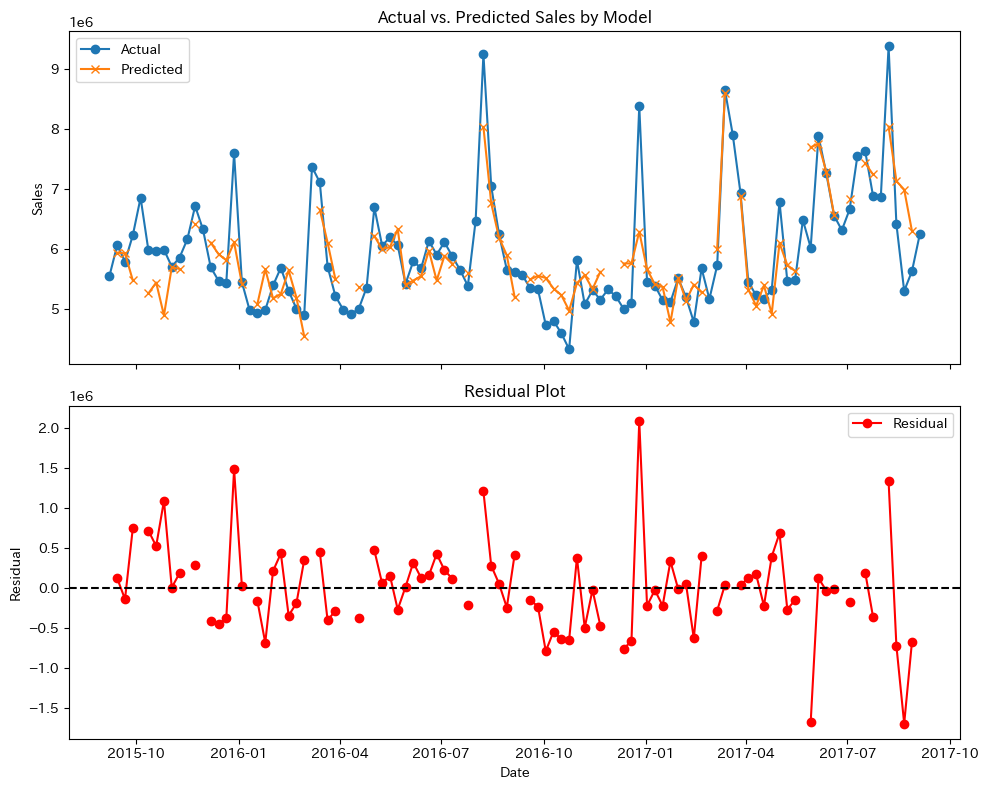

In [11]:
df_actual['Predicted'] = model.fittedvalues
df_actual['Residual'] = model.resid

df_actual.sort_values('Date', inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(df_actual['Date'], df_actual['Sales'], label='Actual', marker='o')
axes[0].plot(df_actual['Date'], df_actual['Predicted'], label='Predicted', marker='x')
axes[0].set_ylabel('Sales')
axes[0].set_title('Actual vs. Predicted Sales by Model')
axes[0].legend()

axes[1].plot(df_actual['Date'], df_actual['Residual'], label='Residual', color='red', marker='o')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].set_title('Residual Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Model's Insight

The training results show that the model explains roughly 64% of the variation in Sales (R² = 0.641, Adjusted R² = 0.580) on the training set, and the test performance is similar (Test R² ≈ 0.631), which indicates good generalization. Here are some key insights:

1. Overall Fit:
- The model has a moderate to good fit, with about 64% of the variance in Sales explained by the predictors on the training set and about 63% on the test set.
- The F-statistic is significant (p < 0.001), meaning that, overall, the model is statistically significant.
2. Key Predictors:
- Digital_Ads: Has a strong, highly significant positive effect (coef ≈ 34.03, p < 0.001). This suggests that for every one-unit increase in Digital_Ads, Sales increase by roughly 34 units.
- Offline_Ads: Has a significant negative effect (coef ≈ -0.0373, p = 0.016), implying that increases in Offline_Ads are associated with a reduction in Sales, which may be counterintuitive and worth further investigation.
- TVCM_GPR: The coefficient is positive (≈ 1534.27) but only marginally significant (p = 0.069).
- Print_Media: Similarly, its coefficient (≈ 0.0124) is marginally significant (p = 0.064).
3. Monthly Dummies:
- The dummy variables for months (from 2月 to 12月) do not appear individually significant, suggesting that either their seasonal effects are modest or that multicollinearity (indicated by a high condition number of ~7.05e+07) is affecting their estimates.
4. Model Diagnostics:
- The Durbin-Watson statistic (1.909) is close to 2, which suggests that there is no serious autocorrelation in the residuals.
- However, the Omnibus and Jarque-Bera tests indicate that the residuals deviate from a normal distribution (p < 0.001 for JB), which might be a concern for inference, though it doesn’t necessarily harm prediction accuracy.
5. Test Performance:
- A Test RMSE of approximately 530,837 indicates that on average, the model’s predictions deviate from the actual Sales by about 530,837 units.
- Whether this is acceptable depends on the scale of Sales; if Sales are in the range of several million, this error may be reasonable.
- The Test R² of ~0.631 confirms that the model performs similarly on unseen data as on the training data.

◾️Overall:
- The model has decent predictive power on the test set with an R² of around 63%, but there are some issues to address. 
- Multicollinearity appears to be a problem (as indicated by the high condition number), and some predictors (TVCM_GPR and Print_Media) are only marginally significant. 
- The significant positive effect of Digital_Ads is robust, while the negative effect of Offline_Ads warrants further investigation. 
- You might consider further variable selection, addressing multicollinearity, or exploring non-linear relationships to improve the model’s stability and interpretability.

# Forecast

Forecast Results:
      Date  Forecast_Sales
2017-09-11    5.731978e+06
2017-09-18    6.014048e+06
2017-09-25    5.707114e+06
2017-10-02    5.524683e+06
2017-10-09    5.412986e+06
2017-10-16    5.311350e+06
2017-10-23    4.602053e+06
2017-10-30    5.816694e+06
2017-11-06    5.772259e+06
2017-11-13    5.502783e+06
2017-11-20    6.074622e+06
2017-11-27    6.229823e+06
2017-12-04    6.045516e+06
2017-12-11    5.997431e+06
2017-12-18    5.719275e+06
2017-12-25    6.500824e+06


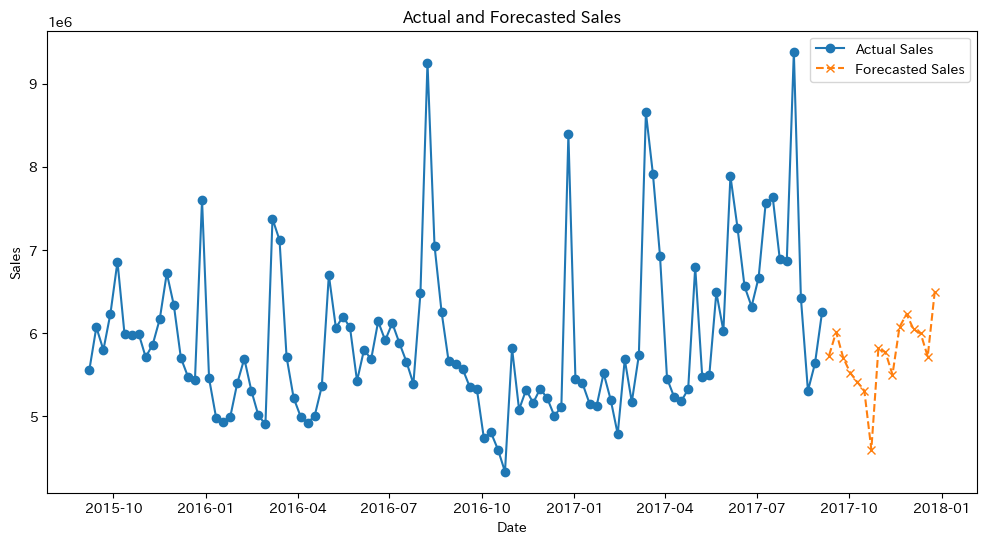

In [12]:
df_actual_combined = pd.concat([df_actual.loc[X_train.index], df_actual.loc[X_test.index]])
df_actual_combined = df_actual_combined.sort_values('Date')

df_forecast = df[df['Record_Type'] == "Forecast"].copy()

dummy_cols = [f'{i}月' for i in range(2, 13)]
X_forecast = df_forecast[['TVCM_GPR', 'Print_Media', 'Offline_Ads', 'Digital_Ads'] + dummy_cols]
X_forecast = sm.add_constant(X_forecast)

df_forecast['Forecast_Sales'] = model.predict(X_forecast)

df_combined = pd.concat([df_actual_combined, df_forecast])
df_combined = df_combined.sort_values('Date')

print("Forecast Results:")
print(df_forecast[['Date', 'Forecast_Sales']].to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_actual_combined['Date'], df_actual_combined['Sales'], label='Actual Sales', marker='o')
plt.plot(df_forecast['Date'], df_forecast['Forecast_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Forecasted Sales')
plt.legend()
plt.show()